## Building a model for the MICCAI 2020 HEad and neCK TumOR Task2 [(HECKTOR)](https://www.aicrowd.com/challenges/miccai-2021-hecktor)

In [1]:
import os
import sys
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch.utils.data import DataLoader
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
sys.path.append('../src/')
import dataset
import transforms
import losses
import metrics
import trainer
import models
from torch.nn import functional as F

from data import utils


In [3]:
import pickle
def load_pickle(file: str, mode: str = 'rb'):
    with open(file, mode) as f:
        a = pickle.load(f)
    return a

In [4]:
train_val_split = load_pickle('/home/sysgen/gitlab/HNSCC-ct-pet-tumor-segmentation/task2_PFS_predict/src/data/nnUNet_splits/splits_final.pkl')
train_val_split

[OrderedDict([('train',
               array(['CHGJ007', 'CHGJ008', 'CHGJ010', 'CHGJ013', 'CHGJ015', 'CHGJ016',
                      'CHGJ017', 'CHGJ018', 'CHGJ025', 'CHGJ026', 'CHGJ028', 'CHGJ029',
                      'CHGJ030', 'CHGJ031', 'CHGJ034', 'CHGJ037', 'CHGJ043', 'CHGJ046',
                      'CHGJ048', 'CHGJ050', 'CHGJ052', 'CHGJ053', 'CHGJ057', 'CHGJ058',
                      'CHGJ065', 'CHGJ066', 'CHGJ069', 'CHGJ070', 'CHGJ071', 'CHGJ072',
                      'CHGJ073', 'CHGJ074', 'CHGJ077', 'CHGJ078', 'CHGJ080', 'CHGJ081',
                      'CHGJ082', 'CHGJ083', 'CHGJ086', 'CHGJ089', 'CHGJ091', 'CHGJ092',
                      'CHMR001', 'CHMR004', 'CHMR011', 'CHMR012', 'CHMR013', 'CHMR014',
                      'CHMR016', 'CHMR020', 'CHMR021', 'CHMR023', 'CHMR024', 'CHMR028',
                      'CHMR029', 'CHMR030', 'CHMR040', 'CHUM001', 'CHUM002', 'CHUM006',
                      'CHUM007', 'CHUM008', 'CHUM011', 'CHUM012', 'CHUM013', 'CHUM014',
        

In [5]:
fold = 1

**The path to the directory with preprocessed (resampled and cropped) images (see notebooks/make_dataset.ipynb for details):**

In [6]:
path_to_data = pathlib.Path('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/')

**Get paths to all files in the dataset:**

In [7]:
all_paths = utils.get_paths_to_patient_files(path_to_imgs=path_to_data, append_mask=True, get_sin=True)

path_to_imgs: /mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled
patients: ['CHUS068', 'CHGJ052', 'CHUS058', 'CHUS020', 'CHGJ065', 'CHUM027', 'CHGJ008', 'CHMR023', 'CHMR024', 'CHGJ092', 'CHUM012', 'CHUS100', 'CHUS096', 'CHUP014', 'CHUS015', 'CHUM024', 'CHUS061', 'CHUP016', 'CHUS085', 'CHUM063', 'CHGJ067', 'CHMR020', 'CHUS030', 'CHMR001', 'CHUP005', 'CHMR028', 'CHGJ007', 'CHUS013', 'CHUM058', 'CHUS053', 'CHUM048', 'CHGJ083', 'CHUM007', 'CHUS041', 'CHGJ043', 'CHUS040', 'CHUM033', 'CHUM038', 'CHGJ028', 'CHUS080', 'CHGJ038', 'CHUM047', 'CHUS010', 'CHMR021', 'CHUS008', 'CHUM041', 'CHUM045', 'CHUS066', 'CHUS043', 'CHGJ035', 'CHGJ037', 'CHUP012', 'CHUS081', 'CHUS028', 'CHMR040', 'CHUS048', 'CHGJ073', 'CHGJ053', 'CHGJ039', 'CHGJ074', 'CHGJ017', 'CHUM006', 'CHMR016', 'CHUM043', 'CHUS083', 'CHGJ015', 'CHUS088', 'CHUM044', 'CHUS019', 'CHGJ062', 'CHUS051', 'CHUS089', 'CHUP013', 'CHUS045', 'CHUM065', 'CHUS056', 'CHUS087', 'CHUS033', 'CHUM014', 'CHUS006', 'CHGJ032', 'CHUP023', 'CHGJ050', 'CHU

In [8]:
# paths for the first patient
all_paths[0]

(PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS068_ct.nii.gz'),
 PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS068_ptsin.nii.gz'),
 PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS068_gtvt.nii.gz'))

In [9]:
print(f'Total number of patients: {len(all_paths)}')

Total number of patients: 224


**Split all patients into train and validation folds using IDs saved in pkl files. There are four splits in total.**

In [10]:
# split 0

#path_to_pkl = '../src/data/splits/train_val_split_0.pkl'
path_to_pkl = '../src/data/nnUNet_splits/splits_final.pkl'
path_to_pkl = '/mnt/faststorage/jintao/nnUNet/nnUNet_preprocessed/Task229_hecktor_base_focal/splits_final.pkl'
path_to_PFS_csv = pathlib.Path('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/hecktor2021_patient_endpoint_training.csv')
PFS_df = pd.read_csv(path_to_PFS_csv)

In [11]:
mean = PFS_df['Progression free survival'].mean()
std = PFS_df['Progression free survival'].std()
print(mean, std)

1223.84375 601.9005084839426


In [12]:
#train_paths, val_paths = utils.get_train_val_paths(all_paths=all_paths, path_to_train_val_pkl=path_to_pkl)
train_paths, val_paths = utils.get_nnUnet_train_val_paths(all_paths=all_paths, path_to_train_val_pkl=path_to_pkl, fold=fold)


In [13]:
train_paths

[(PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS068_ct.nii.gz'),
  PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS068_ptsin.nii.gz'),
  PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS068_gtvt.nii.gz')),
 (PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHGJ052_ct.nii.gz'),
  PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHGJ052_ptsin.nii.gz'),
  PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHGJ052_gtvt.nii.gz')),
 (PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS058_ct.nii.gz'),
  PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS058_ptsin.nii.gz'),
  PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS058_gtvt.nii.gz')),
 (PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/resampled/CHUS020_ct.nii.gz'),
  PosixPath('/mnt/faststorage/jintao/HNSCC/hecktor2021_train/r

In [14]:
print(f'Total number of patients in TRAIN fold: \t{len(train_paths)}')
print(f'Total number of patients in VAL fold: \t\t{len(val_paths)}')

Total number of patients in TRAIN fold: 	179
Total number of patients in VAL fold: 		45


In this example we will use only a single CPU, so let's keep just a couple of patients for training and validation.

** Data Transforms:**

In [15]:
"""train_transforms = transforms.Compose([
    transforms.RandomRotation(p=0.5, angle_range=[0, 45]),
    transforms.Mirroring(p=0.5),
    transforms.NormalizeIntensity(),
    transforms.ToTensor()
])
"""
train_transforms = transforms.Compose([
    transforms.RandomRotation(p=0.5, angle_range=[0, 20]),
    transforms.NormalizeIntensity(),
    transforms.ToTensor()
])


val_transforms = transforms.Compose([
    transforms.NormalizeIntensity(),
    transforms.ToTensor()
])

**Datasets and DataLoaders:**

In [16]:
# parameters:

train_batch_size = 4
val_batch_size = 1
num_workers = 32  # for example, use a number of CPU cores

# Datasets:
train_set = dataset.HecktorDataset(train_paths, PFS_df, transforms=train_transforms)
val_set = dataset.HecktorDataset(val_paths, PFS_df, transforms=val_transforms)

# Dataloaders:
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=val_batch_size, shuffle=False, num_workers=num_workers)

dataloaders = {
    'train': train_loader,
    'val': val_loader
    
}

**One training sample:**

In [17]:
train_sample = next(iter(train_loader))

In [18]:
train_sample.keys()

dict_keys(['id', 'input', 'target', 'PFS'])

In [19]:
train_sample['PFS'], train_sample['id']

(tensor([0.8543, 0.6367, 0.4147, 0.4977]),
 ['CHGJ025', 'CHUS026', 'CHGJ074', 'CHMR013'])

In [20]:
print(f'Patient: \t{train_sample["id"]}')
print(f'Input: \t\t{train_sample["input"].size()}')
print(f'Target: \t{train_sample["target"].size()}')
print(f'Target: \t{train_sample["PFS"].size()}')

Patient: 	['CHGJ025', 'CHUS026', 'CHGJ074', 'CHMR013']
Input: 		torch.Size([4, 2, 144, 144, 144])
Target: 	torch.Size([4, 1, 144, 144, 144])
Target: 	torch.Size([4])


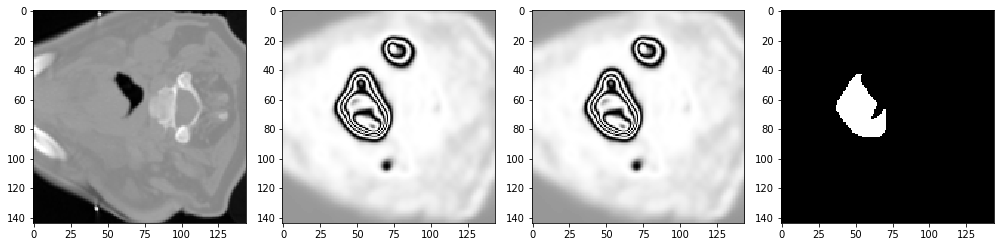

In [21]:
img = train_sample['input'][0]
mask = train_sample['target'][0]

s = 83

fig, axes = plt.subplots(1, 4, figsize=(14, 10))
axes[0].imshow(img[0, :, :, s], cmap=plt.cm.Greys_r, interpolation='none')
axes[1].imshow(img[1, :, :, s], cmap=plt.cm.Greys_r, interpolation='none')
axes[2].imshow(img[1, :, :, s], cmap=plt.cm.Greys_r, interpolation='none')
axes[3].imshow(mask[0, :, :, s], cmap=plt.cm.Greys_r, interpolation='none')
plt.tight_layout()
plt.show()

**Training:**

In [22]:
# parameters:

n_cls = 1  # number of classes
lr = 3e-6 # initial learning rate
n_epochs = 150  # number of epochs

In [23]:
from torch import Tensor

def CanberraMetric1(y_pred, y):
    
    errors = torch.abs(y - y_pred) / (torch.abs(y_pred) + torch.abs(y) + 1e-15)

    _sum_of_errors = torch.sum(errors)

    return _sum_of_errors
        
def MeanAbsoluteRelativeError(y_pred, y):
    return torch.mean(torch.abs(y_pred - y.view_as(y_pred)) / torch.abs(y.view_as(y_pred)))
    
class CanberraHuberLoss(torch.nn.Module):


    def __init__(self) -> None:
        super(CanberraHuberLoss, self).__init__()

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return CanberraMetric1(input, target) + 2*F.huber_loss(input, target, reduction='mean', delta=1) 
    
    

**The model described in the paper had *n_filters=24* !**

In [24]:
#from lifelines.utils import concordance_index
#from ignite.contrib.metrics.regression import CanberraMetric
from livelossplot import PlotLosses

model = models.FastSmoothSENormDeepEncoder_supervision_skip_no_drop(in_channels=2, n_cls=1, n_filters=24)
#model = models.Encoder(in_channels=3, n_cls=1, n_filters=64)
#criterion = torch.nn.MSELoss()
#criterion = torch.nn.HuberLoss()
#criterion = CanberraMAELoss()
criterion = CanberraHuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))

T_0= 25  # parameter for 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'
eta_min= 1e-8  # parameter for 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, eta_min=eta_min)

metric = CanberraMetric1 #MeanAbsoluteRelativeError

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print(get_n_params(model))

1163651297


In [25]:
trainer_ = trainer.ModelTrainer(model=model,
                                dataloaders=dataloaders,
                                criterion=criterion,
                                optimizer=optimizer,
                                metric=metric,
                                scheduler=None,
                                num_epochs=n_epochs,
                                save_last_model=True,
                                livelossplot = True)

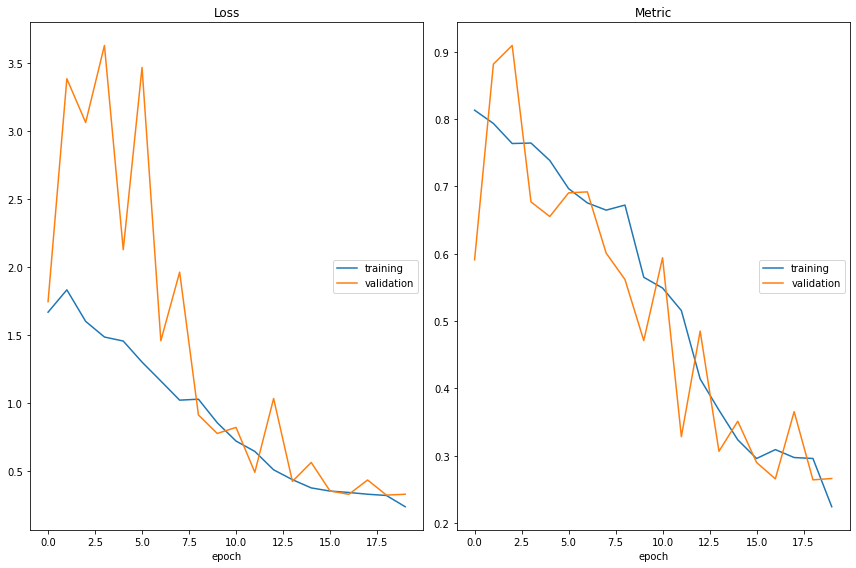

Loss
	training         	 (min:    0.238, max:    1.832, cur:    0.238)
	validation       	 (min:    0.324, max:    3.628, cur:    0.330)
Metric
	training         	 (min:    0.224, max:    0.813, cur:    0.224)
	validation       	 (min:    0.264, max:    0.909, cur:    0.266)
Epoch 20 / 149
--------------------
batch: 0 batch loss: 1.222 	metric: 1.132
batch: 1 batch loss: 1.730 	metric: 1.690
batch: 2 batch loss: 1.127 	metric: 1.083
batch: 3 batch loss: 1.040 	metric: 1.003
batch: 4 batch loss: 0.539 	metric: 0.526
batch: 5 batch loss: 0.723 	metric: 0.689
batch: 6 batch loss: 0.424 	metric: 0.408
batch: 7 batch loss: 1.770 	metric: 1.712
batch: 8 batch loss: 1.659 	metric: 1.562
batch: 9 batch loss: 1.466 	metric: 1.417
batch: 10 batch loss: 1.122 	metric: 1.082
batch: 11 batch loss: 1.706 	metric: 1.617
batch: 12 batch loss: 0.180 	metric: 0.173
batch: 13 batch loss: 1.241 	metric: 1.013
batch: 14 batch loss: 0.715 	metric: 0.678
batch: 15 batch loss: 0.387 	metric: 0.380
batch: 16 

In [ ]:
trainer_.train_model()

**After training, we need to define a directory to save all results.**

* 'best_model_weights.pt' - weights (state_dict) of the best model received during training on the validation set.
* 'last_model_checkpoint.tar' - the last checkpoint (weights of the last model and the optimizer’s state).
* 'learning_curves.csv' - learning curves.
* 'loss_plot.png', 'metric_plot.png' - plots with the learning curves.
* 'summary.csv' - the short summary.

In [ ]:
path_to_save_dir = pathlib.Path('/home/sysgen/gitlab/HNSCC-ct-pet-tumor-segmentation/task2_PFS_predict/results_CH_sine/fold-'+str(fold)+'/')

In [ ]:
trainer_.save_results(path_to_save_dir)

In [ ]:
import pandas as pd

In [ ]:
summary = pd.read_csv(path_to_save_dir / 'summary.csv')
summary

In [ ]:
#predict.py -p ../config/model_predict.yaml -f 0


In [ ]:
#checkpoint = torch.load('filename.pth.tar')
#model.load_state_dict(checkpoint['state_dict'])